In [1]:
import pandas as pd
import requests, zipfile, io, re, nltk
from datetime import datetime, timedelta
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.text import Tokenizer 
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading Raw Data

In [3]:
raw_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None,
                         names=['polarity', 'id', 'date', 'query', 'user', 'tweet'])
raw_df

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Data Preprocessing

## Removing Unnecessary Data

In [4]:
df = raw_df.drop(columns=['id', 'query', 'polarity', 'user', 'date'])
# df['datetime'] = raw_df['date'].apply(lambda x: pd.to_datetime(x.replace('PDT ', '')))
df

,tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."
...,...
1599995,Just woke up. Having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...


## Define and scale y from {0, 4} to {0, 1}

In [5]:
y = raw_df['polarity']
print(f"Unique Elements of raw y: {pd.unique(y)}")
y = y.apply(lambda x: 1 if x==4 else 0)
y

Unique Elements of y: [0 4]


0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: polarity, Length: 1600000, dtype: int64

## Remove URLs and @ Handles from Tweets

In [6]:
processed_df = df.copy(deep=True)

# Define tokenizer to split tweet into word tokens
tokenizer = RegexpTokenizer(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|\w+|[^\w\s]+")


# Remove URLs and User Mentions. All Twitter handles must be within 4 to 15 characters
processed_df['tweet'] = processed_df['tweet'].apply(lambda x: re.sub(r"http\S+|@\w{4,15}|#", "", x))
processed_df

,tweet
0,"- Awww, that's a bummer. You shoulda got Da..."
1,is upset that he can't update his Facebook by ...
2,I dived many times for the ball. Managed to s...
3,my whole body feels itchy and like its on fire
4,"no, it's not behaving at all. i'm mad. why am..."
...,...
1599995,Just woke up. Having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...


## Tokenize Tweets into Sentences


In [7]:
processed_df['sentence_tokens'] = processed_df['tweet'].apply(lambda x: sent_tokenize(x))
processed_df

## Extract Part-Of-Speech Tags

In [8]:
processed_df['pos_tags'] = processed_df['sentence_tokens'].apply(lambda x: [nltk.pos_tag(tokenizer.tokenize(sent)) for sent in x])
processed_df

,tweet,sentence_tokens,pos_tags
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ..."
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP..."
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ..."
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,..."
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB..."
...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I..."
1599998,Happy 38th Birthday to my boo of alll time!!! ...,[Happy 38th Birthday to my boo of alll time!!!...,"[[(Happy, JJ), (38th, CD), (Birthday, NN), (to..."


## Create word tokens from tweets

In [9]:
# pattern = regex.compile(r"(.)/\1{2,}")
# pattern.sub(r"\1\1\1", text)
processed_df['word_tokens'] = processed_df['tweet'].apply(lambda x: tokenizer.tokenize(x))
processed_df

,tweet,sentence_tokens,pos_tags,word_tokens
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh..."
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ..."
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man..."
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its..."
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i..."
...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?..."
1599998,Happy 38th Birthday to my boo of alll time!!! ...,[Happy 38th Birthday to my boo of alll time!!!...,"[[(Happy, JJ), (38th, CD), (Birthday, NN), (to...","[Happy, 38th, Birthday, to, my, boo, of, alll,..."


## Generate and remove stop words from word tokens

In [10]:
# Generate stop words
print("Stop Words: ", stopwords.words('english'))
stop_words = set(stopwords.words('english'))
# Remove stop words from tokenized tweets
processed_df['word_tokens_no_stop_words'] = processed_df['word_tokens'].apply(lambda x: [w for w in x if not w.lower() in stop_words])
processed_df

Stop Words:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

,tweet,sentence_tokens,pos_tags,word_tokens,word_tokens_no_stop_words
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh...","[-, Awww, ,, ', bummer, ., shoulda, got, David..."
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ...","[upset, ', update, Facebook, texting, ..., mig..."
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man...","[dived, many, times, ball, ., Managed, save, 5..."
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i...","[,, ', behaving, ., ', mad, ., ?, ', see, .]"
...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th...","[woke, ., school, best, feeling, ever]"
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,...","[TheWDB, ., com, -, cool, hear, old, Walt, int..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?...","[ready, MoJo, Makeover, ?, Ask, details]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,[Happy 38th Birthday to my boo of alll time!!!...,"[[(Happy, JJ), (38th, CD), (Birthday, NN), (to...","[Happy, 38th, Birthday, to, my, boo, of, alll,...","[Happy, 38th, Birthday, boo, alll, time, !!!, ..."


## Stemming words in Tweet

In [12]:
ps = PorterStemmer()
processed_df['word_tokens_no_stop_stemmed'] = processed_df['word_tokens_no_stop_words'].apply(lambda x: [ps.stem(w) for w in x if not w == ''])
processed_df

,tweet,sentence_tokens,pos_tags,word_tokens,word_tokens_no_stop_words,pos_tags_adjusted_no_stop_words,word_tokens_no_stop_stemmed
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh...","[-, Awww, ,, ', bummer, ., shoulda, got, David...","[(-, None), (Awww, n), (,, None), (', None), (...","[-, awww, ,, ', bummer, ., shoulda, got, david..."
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ...","[upset, ', update, Facebook, texting, ..., mig...","[(upset, a), (', None), (update, v), (Facebook...","[upset, ', updat, facebook, text, ..., might, ..."
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man...","[dived, many, times, ball, ., Managed, save, 5...","[(dived, v), (many, a), (times, n), (ball, n),...","[dive, mani, time, ball, ., manag, save, 50, %..."
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, n), (itchy, v)...","[whole, bodi, feel, itchi, like, fire]"
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i...","[,, ', behaving, ., ', mad, ., ?, ', see, .]","[(,, None), (', None), (behaving, v), (., None...","[,, ', behav, ., ', mad, ., ?, ', see, .]"
...,...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th...","[woke, ., school, best, feeling, ever]","[(woke, v), (., None), (school, n), (best, a),...","[woke, ., school, best, feel, ever]"
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,...","[TheWDB, ., com, -, cool, hear, old, Walt, int...","[(TheWDB, n), (., None), (com, n), (-, None), ...","[thewdb, ., com, -, cool, hear, old, walt, int..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?...","[ready, MoJo, Makeover, ?, Ask, details]","[(ready, a), (MoJo, n), (Makeover, n), (?, Non...","[readi, mojo, makeov, ?, ask, detail]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,[Happy 38th Birthday to my boo of alll time!!!...,"[[(Happy, JJ), (38th, CD), (Birthday, NN), (to...","[Happy, 38th, Birthday, to, my, boo, of, alll,...","[Happy, 38th, Birthday, boo, alll, time, !!!, ...","[(Happy, a), (38th, None), (Birthday, n), (boo...","[happi, 38th, birthday, boo, alll, time, !!!, ..."


## Remove Stop Words and Lemmatize Words in Tweets

In [11]:
# Map POS tags from pos tagger to tags accepted by WordNetLemmatizer
# Source: https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py
def penn2morphy(penntag) -> str:
    """
    Converts tags from Penn format (input: single string) to Morphy.
    """
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return None

# Adjust POS tags based on mappings and remove stop words
processed_df['pos_tags_adjusted_no_stop_words'] = processed_df['pos_tags'].apply(
    lambda x: [(w[0], penn2morphy(w[1])) for s in x for w in s if not w[0].lower() in stop_words])

# Lemmatizing words in Tweet
lemmatizer = WordNetLemmatizer()
processed_df['word_tokens_no_stop_lemmatized'] = processed_df['pos_tags_adjusted_no_stop_words'].apply(lambda x: [lemmatizer.lemmatize(word=w[0].lower(), pos=w[1]) if w[1] != None else w[0].lower() for w in x])
processed_df

processed_df

,tweet,sentence_tokens,pos_tags,word_tokens,word_tokens_no_stop_words,pos_tags_adjusted_no_stop_words
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh...","[-, Awww, ,, ', bummer, ., shoulda, got, David...","[(-, None), (Awww, n), (,, None), (', None), (..."
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ...","[upset, ', update, Facebook, texting, ..., mig...","[(upset, a), (', None), (update, v), (Facebook..."
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man...","[dived, many, times, ball, ., Managed, save, 5...","[(dived, v), (many, a), (times, n), (ball, n),..."
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, n), (itchy, v)..."
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i...","[,, ', behaving, ., ', mad, ., ?, ', see, .]","[(,, None), (', None), (behaving, v), (., None..."
...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th...","[woke, ., school, best, feeling, ever]","[(woke, v), (., None), (school, n), (best, a),..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,...","[TheWDB, ., com, -, cool, hear, old, Walt, int...","[(TheWDB, n), (., None), (com, n), (-, None), ..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?...","[ready, MoJo, Makeover, ?, Ask, details]","[(ready, a), (MoJo, n), (Makeover, n), (?, Non..."
1599998,Happy 38th Birthday to my boo of alll time!!! ...,[Happy 38th Birthday to my boo of alll time!!!...,"[[(Happy, JJ), (38th, CD), (Birthday, NN), (to...","[Happy, 38th, Birthday, to, my, boo, of, alll,...","[Happy, 38th, Birthday, boo, alll, time, !!!, ...","[(Happy, a), (38th, None), (Birthday, n), (boo..."


## Strip Punctuation

In [2]:
import string
processed_df['tweet_str_no_stop_stemmed'] = processed_df['word_tokens_no_stop_stemmed'].apply(lambda x: ' '.join(x).translate(str.maketrans('', '', string.punctuation)))
processed_df['tweet_str_no_stop_lemmatized'] = processed_df['word_tokens_no_stop_lemmatized'].apply(lambda x: ' '.join(x).translate(str.maketrans('', '', string.punctuation)))
processed_df

NameError: name 'processed_df' is not defined

## Pickle data for later use

In [15]:
# Pickle processed_df
y.to_pickle("y.pickle")
processed_df.to_pickle("processed_df.pickle")

## Load Pickled Data

In [2]:
# Read processed_df from pickle file
processed_df = pd.read_pickle("processed_df.pickle")
y = pd.read_pickle("y.pickle")
processed_df

,tweet,sentence_tokens,pos_tags,word_tokens,word_tokens_no_stop_words,pos_tags_adjusted_no_stop_words,word_tokens_no_stop_stemmed,word_tokens_no_stop_lemmatized,tweet_str_no_stop_stemmed,tweet_str_no_stop_lemmatized
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh...","[-, Awww, ,, ', bummer, ., shoulda, got, David...","[(-, None), (Awww, n), (,, None), (', None), (...","[-, awww, ,, ', bummer, ., shoulda, got, david...","[-, awww, ,, ', bummer, ., shoulda, get, david...",awww bummer shoulda got david carr third d...,awww bummer shoulda get david carr third d...
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ...","[upset, ', update, Facebook, texting, ..., mig...","[(upset, a), (', None), (update, v), (Facebook...","[upset, ', updat, facebook, text, ..., might, ...","[upset, ', update, facebook, texting, ..., mig...",upset updat facebook text might cri result s...,upset update facebook texting might cry resu...
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man...","[dived, many, times, ball, ., Managed, save, 5...","[(dived, v), (many, a), (times, n), (ball, n),...","[dive, mani, time, ball, ., manag, save, 50, %...","[dive, many, time, ball, ., manage, save, 50, ...",dive mani time ball manag save 50 rest go bound,dive many time ball manage save 50 rest go b...
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, n), (itchy, v)...","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]",whole bodi feel itchi like fire,whole body feel itchy like fire
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i...","[,, ', behaving, ., ', mad, ., ?, ', see, .]","[(,, None), (', None), (behaving, v), (., None...","[,, ', behav, ., ', mad, ., ?, ', see, .]","[,, ', behave, ., ', mad, ., ?, ', see, .]",behav mad see,behave mad see
...,...,...,...,...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th...","[woke, ., school, best, feeling, ever]","[(woke, v), (., None), (school, n), (best, a),...","[woke, ., school, best, feel, ever]","[wake, ., school, best, feeling, ever]",woke school best feel ever,wake school best feeling ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,...","[TheWDB, ., com, -, cool, hear, old, Walt, int...","[(TheWDB, n), (., None), (com, n), (-, None), ...","[thewdb, ., com, -, cool, hear, old, walt, int...","[thewdb, ., com, -, cool, hear, old, walt, int...",thewdb com cool hear old walt interview â «,thewdb com cool hear old walt interview â «
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?...","[ready, MoJo, Makeover, ?, Ask, details]","[(ready, a), (MoJo, n), (Makeover, n), (?, Non...","[readi, mojo, makeov, ?, ask, detail]","[ready, mojo, makeover, ?, ask, detail]",r

# GloVe

## Download GloVe Twitter Pre-Trained Vectors

In [ ]:
# Download and Extract GloVe Twitter Vectors
r = requests.get('http://nlp.stanford.edu/data/glove.twitter.27B.zip', stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("GloVe.Twitter.27B")

## Establish KFold and Model Diagnostics Visualization Methods

In [3]:
from sklearn.model_selection import KFold
# Simple Kfold
def kfold(network, neg_tweets, pos_tweets, batch_size):
    kf = KFold(n_splits=5)
    n = 0
    fold_times = []
    histories = []
    if len(neg_tweets) > len(pos_tweets):
        tweets = pos_tweets 
    else: tweets = neg_tweets
    for train_idx, test_idx in kf.split(tweets):
        start = datetime.now()
        print(f"Fold {n}")
        n+=1
        print(f"Test Index Start:{test_idx[0]}")
        print(f"Test Set Size:{len(test_idx)}")
        train_tweets = np.append(neg_tweets[train_idx], pos_tweets[train_idx], axis=0)
        train_labels = np.append(np.full(len(train_idx), 0), np.full(len(train_idx), 1))

        test_tweets = np.append(neg_tweets[test_idx], pos_tweets[test_idx], axis=0)
        test_labels = np.append(np.full(len(test_idx), 0), np.full(len(test_idx), 1))
        validation_data = (test_tweets, test_labels)
        
        history = network.fit(train_tweets, train_labels, batch_size=batch_size, validation_data=validation_data, 
                              epochs=25, verbose=0, use_multiprocessing=True)
        histories.append(history)
        summarize_diagnostics(history=history)
        fold_time = datetime.now()-start
        fold_times.append(fold_time.total_seconds())
        print("fold time: ", fold_time)
    summarize_diagnostics(histories=histories)
    print(timedelta(seconds=np.average(fold_times)))

# Plots results to graph
import matplotlib.pyplot as plt
def summarize_diagnostics(history=None, histories=None):
    # plot loss
    plt.subplot(211)
    plt.tight_layout()
    plt.title('Cross Entropy Loss')
    if history:
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
    else:
        plt.plot(np.mean([history.history['loss'] for history in histories], axis=0), color='blue', label='train')
        plt.plot(np.mean([history.history['val_loss'] for history in histories], axis=0), color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    if history:
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
    else:
        plt.plot(np.mean([history.history['accuracy'] for history in histories], axis=0), color='blue', label='train')
        plt.plot(np.mean([history.history['val_accuracy'] for history in histories], axis=0), color='orange', label='test')
    plt.legend()
    plt.show()

# Model Testing

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                12012     
                                                                 
 dense_7 (Dense)             (None, 8)                 104       
                                                                 
 dense_8 (Dense)             (None, 50)                450       
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 12)                612       
                                                                 
 dense_10 (Dense)            (None, 50)                650       
                                                                 
 dense_11 (Dense)            (None, 1)                

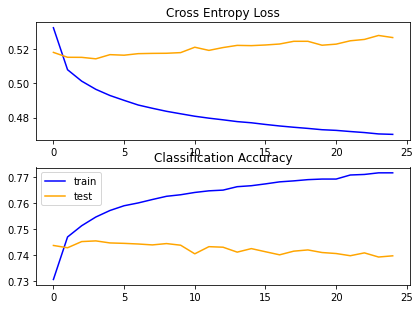

fold time:  0:02:10.970497
Fold 1
Test Index Start:40000
Test Set Size:40000


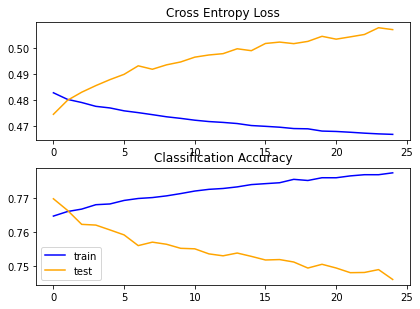

fold time:  0:02:12.967211
Fold 2
Test Index Start:80000
Test Set Size:40000


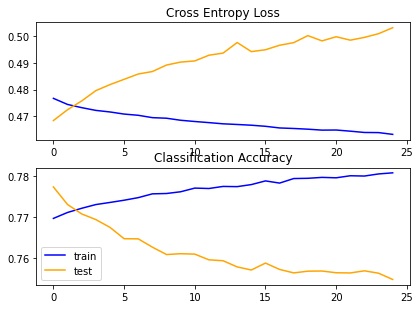

fold time:  0:02:11.287769
Fold 3
Test Index Start:120000
Test Set Size:40000


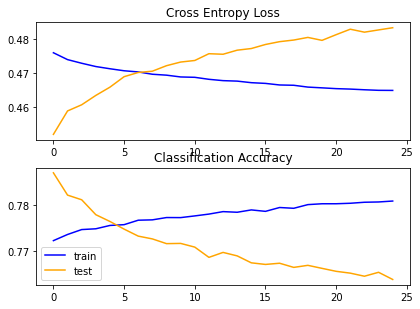

fold time:  0:02:12.573873
Fold 4
Test Index Start:160000
Test Set Size:40000


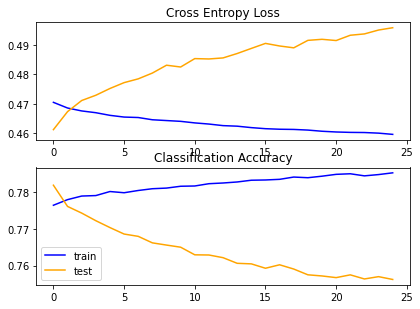

fold time:  0:02:10.529118


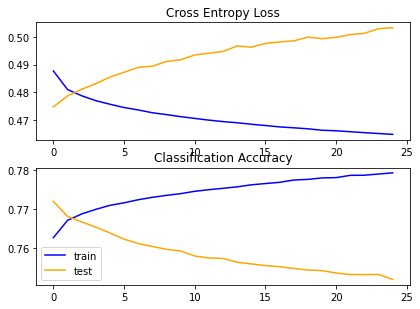

0:02:11.665694


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1000, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compile the model so it can be trained
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

cv=CountVectorizer(max_features=1000)
X=cv.fit_transform(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join)).toarray()
neg_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==0])[:200000]
pos_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==1])[:200000]
print(len(neg_tweets_stem), len(pos_tweets_stem))
kfold(model, neg_tweets_stem, pos_tweets_stem, 256)

## Model adjusted with significant measures to prevent overfitting

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                32032     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________
200000 200000
Fold 0
Test Index Start:0
Test Set Size:40000


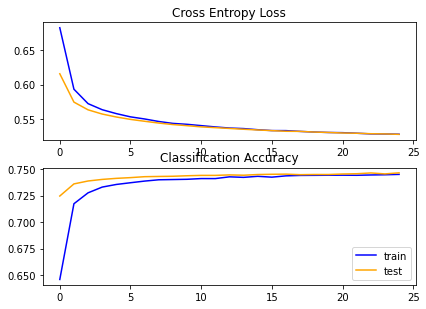

fold time:  0:01:39.026510
Fold 1
Test Index Start:40000
Test Set Size:40000


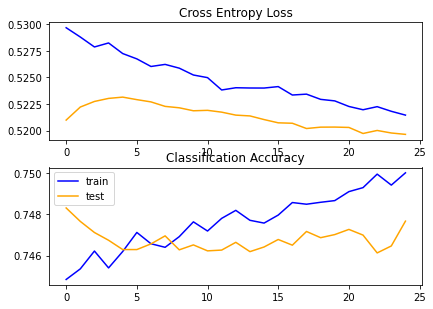

fold time:  0:01:33.780552
Fold 2
Test Index Start:80000
Test Set Size:40000


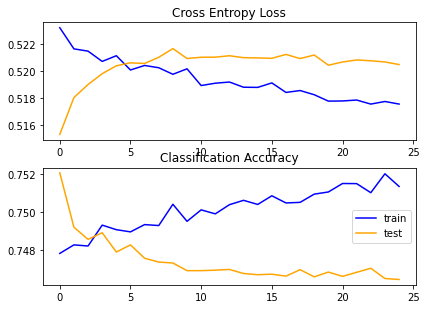

fold time:  0:01:33.063937
Fold 3
Test Index Start:120000
Test Set Size:40000


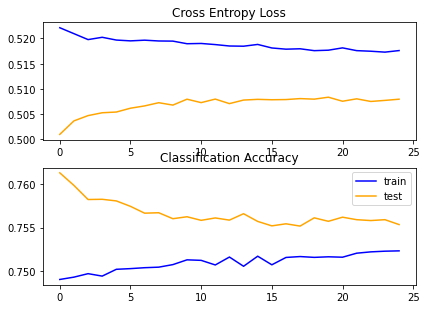

fold time:  0:01:35.238804
Fold 4
Test Index Start:160000
Test Set Size:40000


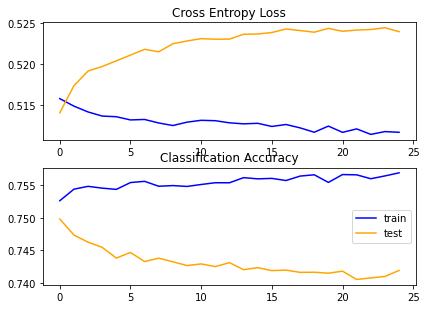

fold time:  0:01:35.269832


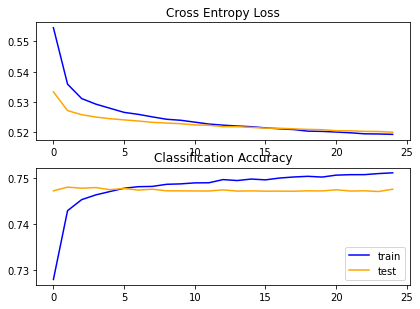

0:01:35.275927


In [10]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

cv=CountVectorizer(max_features=1000)
X=cv.fit_transform(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join)).toarray()
neg_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==0])[:200000]
pos_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==1])[:200000]
print(len(neg_tweets_stem), len(pos_tweets_stem))

kfold(model, neg_tweets_stem, pos_tweets_stem, 256)

## Reduce size of bag of words

200000 200000
Fold 0
Test Index Start:0
Test Set Size:40000


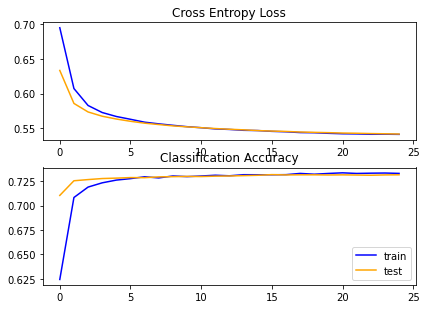

fold time:  0:01:28.622205
Fold 1
Test Index Start:40000
Test Set Size:40000


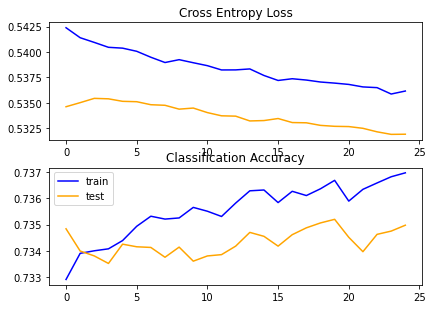

fold time:  0:01:32.170163
Fold 2
Test Index Start:80000
Test Set Size:40000


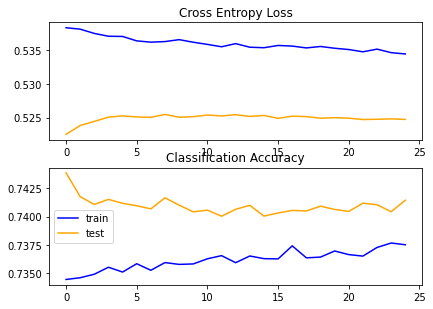

fold time:  0:01:30.157432
Fold 3
Test Index Start:120000
Test Set Size:40000


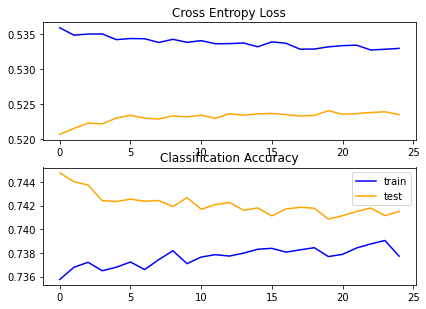

fold time:  0:01:32.955836
Fold 4
Test Index Start:160000
Test Set Size:40000


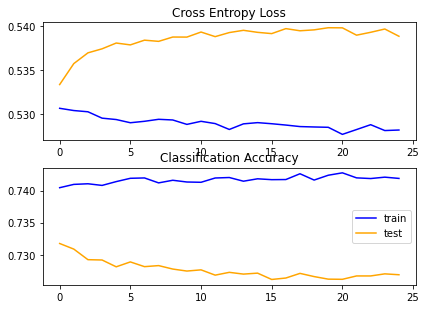

fold time:  0:01:35.253310


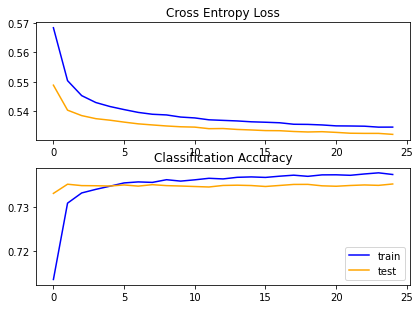

0:01:31.831789


In [7]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=500, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

# Create bag of words featureset for stemmed 
cv=CountVectorizer(max_features=500)
X=cv.fit_transform(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join)).toarray()
neg_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==0 and any(X[i])])[:200000]
pos_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==1 and any(X[i])])[:200000]
print(len(neg_tweets_stem), len(pos_tweets_stem))
kfold(model, neg_tweets_stem, pos_tweets_stem, 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                48032     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,065
Trainable params: 48,065
Non-trainable params: 0
_________________________________________________________________
200000 200000
Fold 0
Test Index Start:0
Test Set Size:40000


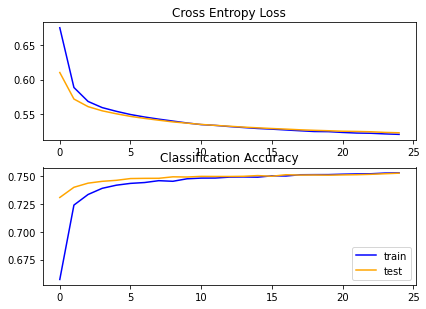

fold time:  0:01:54.382785
Fold 1
Test Index Start:40000
Test Set Size:40000


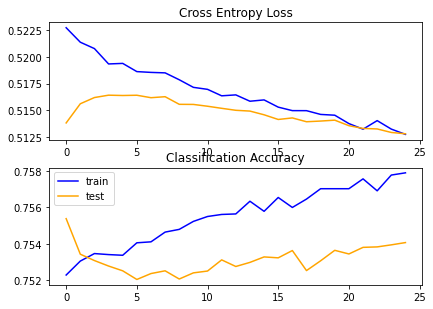

fold time:  0:02:02.181484
Fold 2
Test Index Start:80000
Test Set Size:40000


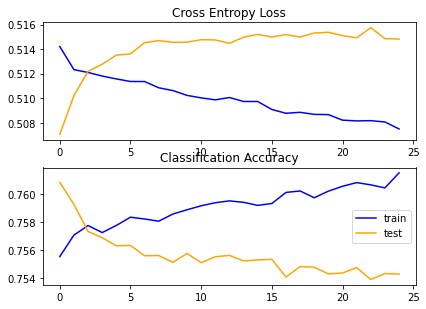

fold time:  0:01:55.631821
Fold 3
Test Index Start:120000
Test Set Size:40000


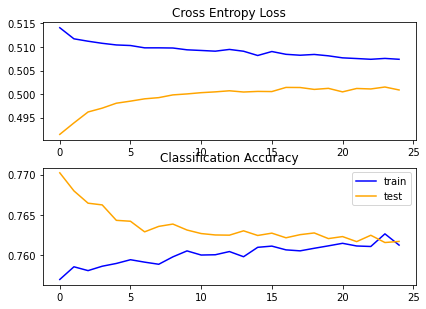

fold time:  0:01:51.486260
Fold 4
Test Index Start:160000
Test Set Size:40000


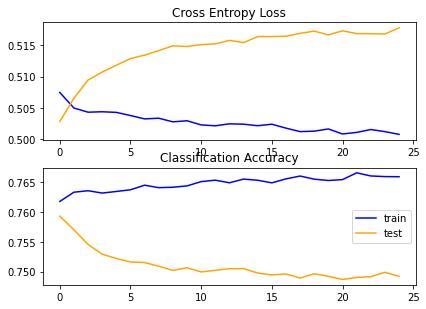

fold time:  0:01:50.994837


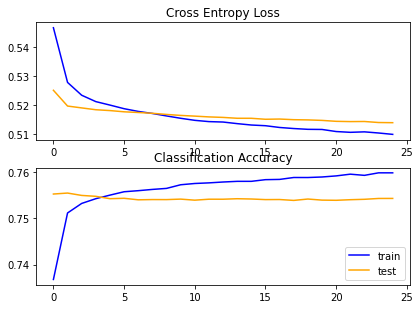

0:01:54.935437


In [4]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=1500, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join)).toarray()
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])[:200000]
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])[:200000]
print(len(neg_tweets_lemm), len(pos_tweets_lemm))

kfold(model, neg_tweets_lemm, pos_tweets_lemm, 256)

In [ ]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 500 Words

Fold 0
Test Index Start:0
Test Set Size:40000


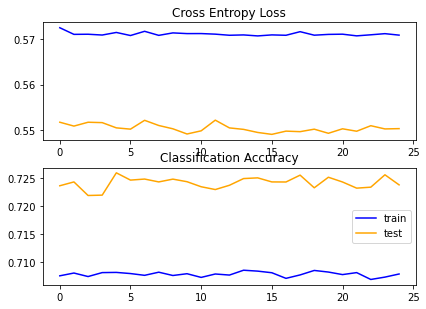

fold time:  0:00:55.740388
Fold 1
Test Index Start:40000
Test Set Size:40000


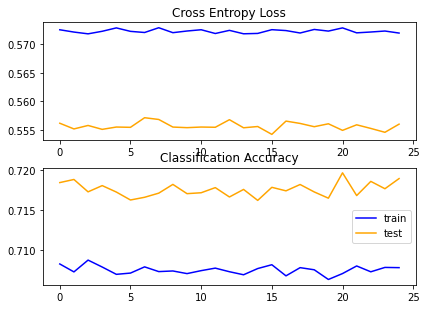

fold time:  0:00:53.801638
Fold 2
Test Index Start:80000
Test Set Size:40000


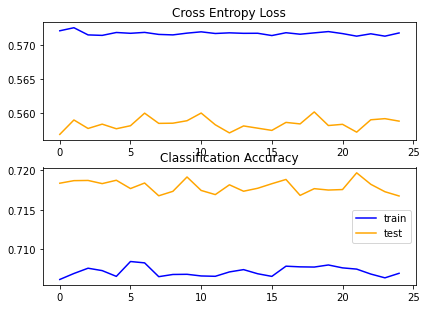

fold time:  0:00:52.847483
Fold 3
Test Index Start:120000
Test Set Size:40000


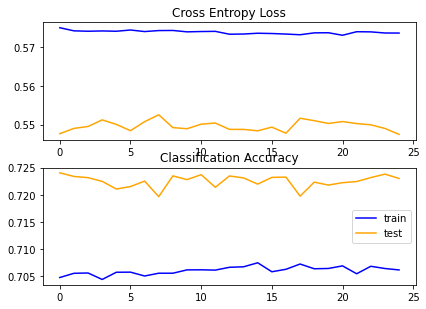

fold time:  0:00:52.699347
Fold 4
Test Index Start:160000
Test Set Size:40000


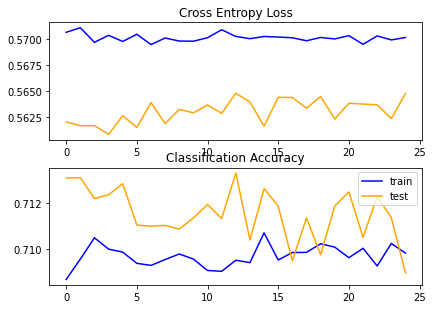

fold time:  0:00:52.744881


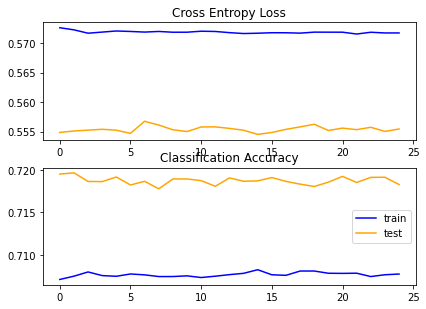

0:00:53.566747


In [25]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layears.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])

kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 1000 Words

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1000, 25)          150       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 500, 25)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 12500)             0         
                                                                 
 dense_8 (Dense)             (None, 16)                200016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                      

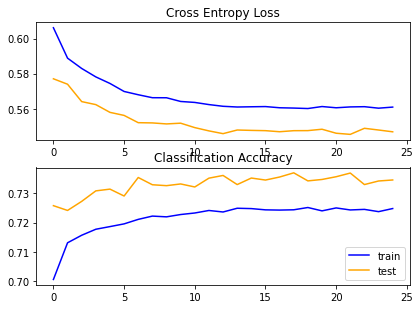

fold time:  0:01:05.652101
Fold 1
Test Index Start:40000
Test Set Size:40000


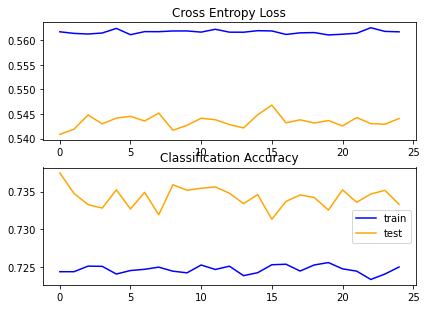

fold time:  0:01:09.318222
Fold 2
Test Index Start:80000
Test Set Size:40000


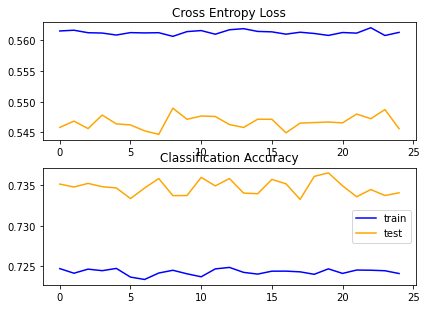

fold time:  0:01:04.343792
Fold 3
Test Index Start:120000
Test Set Size:40000


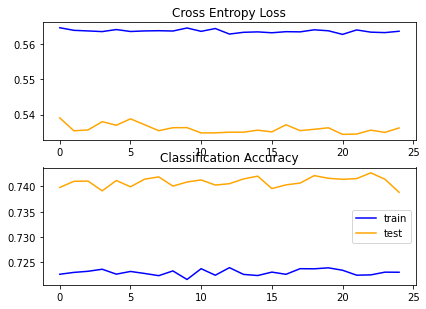

fold time:  0:01:03.508179
Fold 4
Test Index Start:160000
Test Set Size:40000


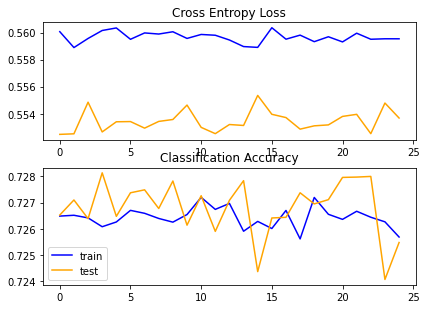

fold time:  0:01:03.181780


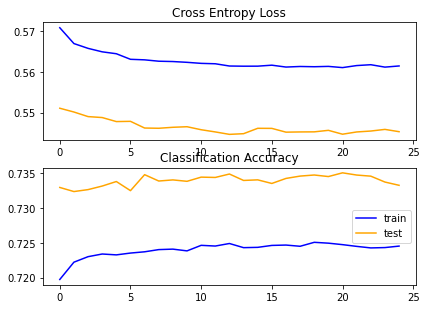

0:01:05.200815


In [26]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1000, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1000)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 1500 Words

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 25)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18750)             0         
                                                                 
 dense (Dense)               (None, 16)                300016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

2022-05-01 16:54:50.148058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 16:54:50.216819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 16:54:50.217600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 16:54:50.219647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Fold 0
Test Index Start:0
Test Set Size:40000


2022-05-01 16:55:40.988993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 16:55:43.035191: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


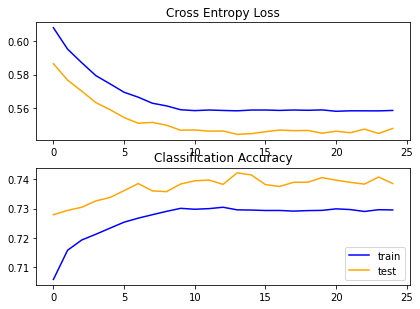

fold time:  0:01:29.472818
Fold 1
Test Index Start:40000
Test Set Size:40000


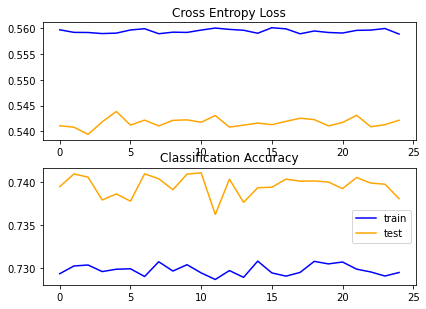

fold time:  0:01:27.898696
Fold 2
Test Index Start:80000
Test Set Size:40000


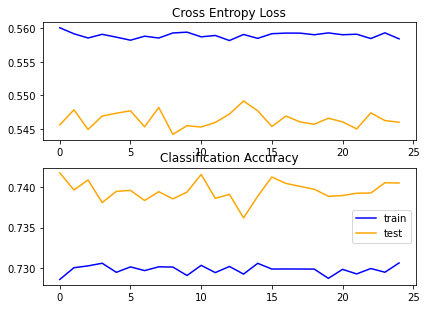

fold time:  0:01:26.490063
Fold 3
Test Index Start:120000
Test Set Size:40000


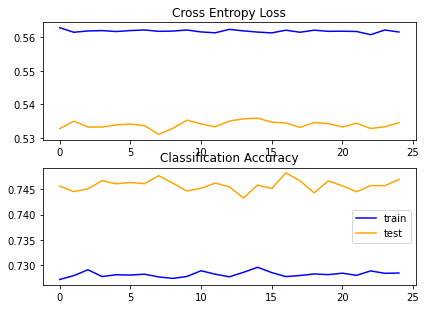

fold time:  0:01:26.573140
Fold 4
Test Index Start:160000
Test Set Size:40000


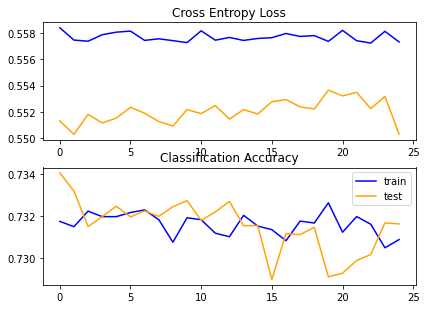

fold time:  0:01:26.244624


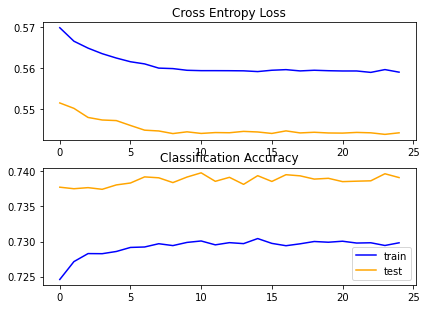

0:01:27.335868


In [4]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 2000 Words (Crashed)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2000, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 25)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 25000)             0         
                                                                 
 dense (Dense)               (None, 16)                400016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

2022-05-01 17:13:17.368082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:13:17.437223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:13:17.438042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:13:17.440176: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Fold 0
Test Index Start:0
Test Set Size:40000


2022-05-01 17:14:13.063977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 17:14:15.103869: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


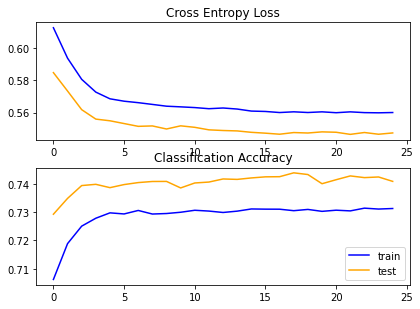

fold time:  0:01:48.219974
Fold 1
Test Index Start:40000
Test Set Size:40000


In [ ]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(2000, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
modeal.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 2000)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 2 Layer 1500 Words

2022-05-01 17:19:45.808093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:19:45.877391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:19:45.878233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 17:19:45.880865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 25)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 12)           912       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 12)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4500)              0         
                                                                 
 dense (Dense)               (None, 16)                7

2022-05-01 17:20:41.659740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 17:20:43.807635: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


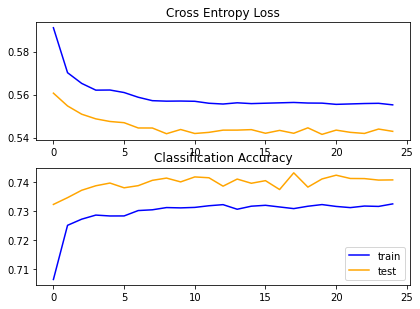

fold time:  0:02:00.800542
Fold 1
Test Index Start:40000
Test Set Size:40000


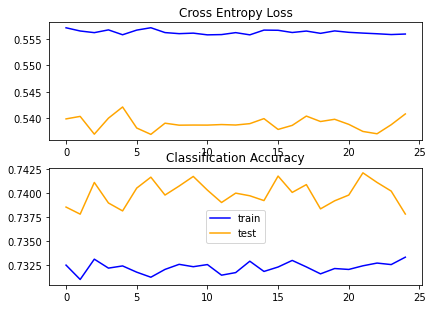

fold time:  0:02:03.279781
Fold 2
Test Index Start:80000
Test Set Size:40000


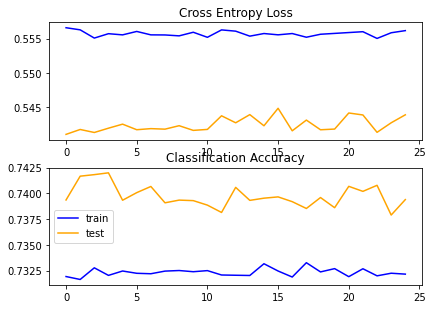

fold time:  0:02:03.577406
Fold 3
Test Index Start:120000
Test Set Size:40000


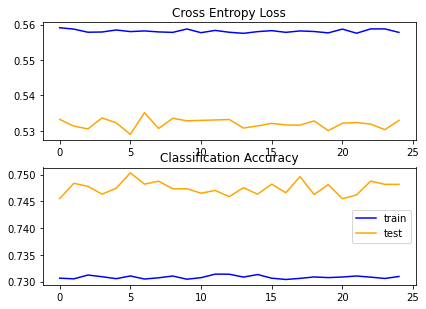

fold time:  0:02:02.920222
Fold 4
Test Index Start:160000
Test Set Size:40000


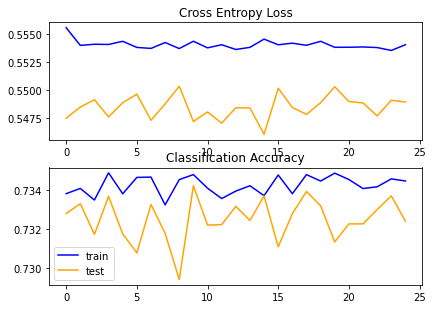

fold time:  0:01:55.878413


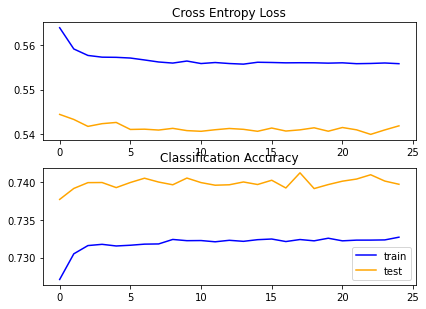

0:02:01.291273


In [5]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 3 Layer 1500 Words

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1500, 32)          192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 750, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 750, 16)           2576      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 375, 16)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 375, 18)           1458      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 187, 18)         

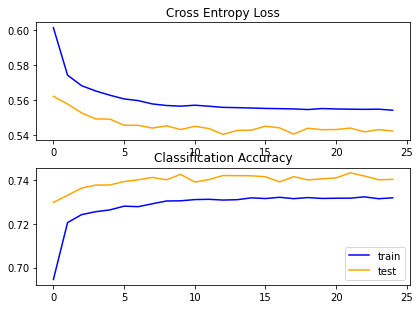

fold time:  0:02:27.729023
Fold 1
Test Index Start:40000
Test Set Size:40000


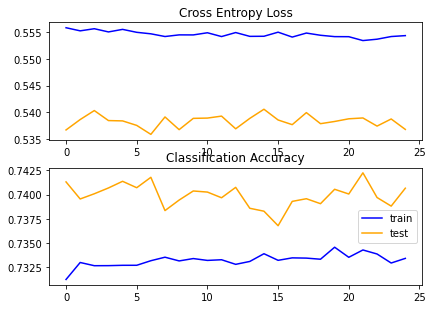

fold time:  0:02:29.786910
Fold 2
Test Index Start:80000
Test Set Size:40000


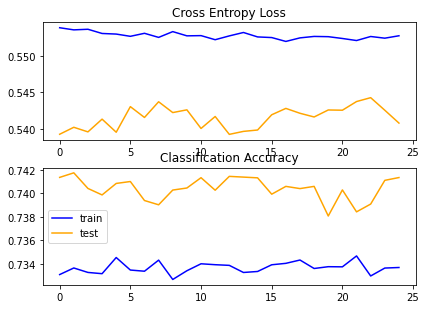

fold time:  0:02:26.797031
Fold 3
Test Index Start:120000
Test Set Size:40000


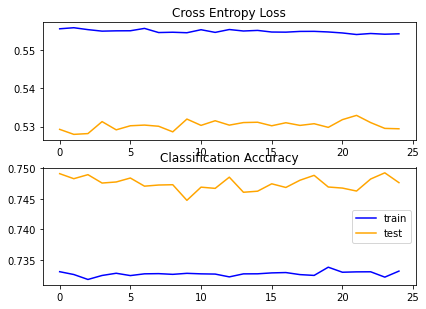

fold time:  0:02:26.497980
Fold 4
Test Index Start:160000
Test Set Size:40000


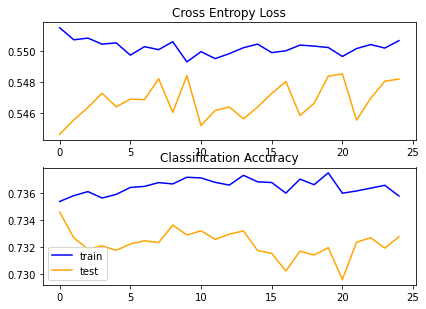

fold time:  0:02:26.772808


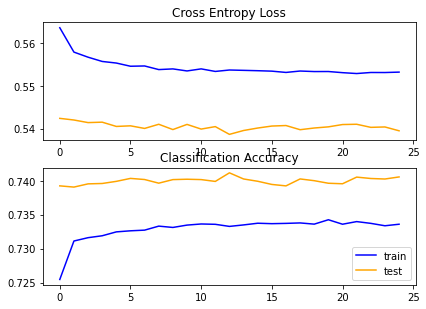

0:02:27.516750


In [6]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 5, padding="same", activation="relu", input_shape=(1500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(16, 5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Conv1D(18, 5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

2 CONV2D layers sufficient w 1500 words

## CNN 2 Layer Adam Optimizer 1500 Words lr=0.0001

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 25)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 12)           912       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 12)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4500)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

2022-05-01 18:50:32.167602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 18:50:34.362391: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


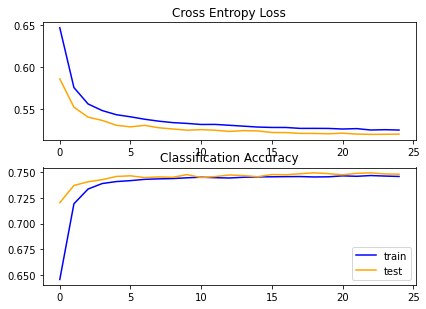

fold time:  0:02:00.082564
Fold 1
Test Index Start:40000
Test Set Size:40000


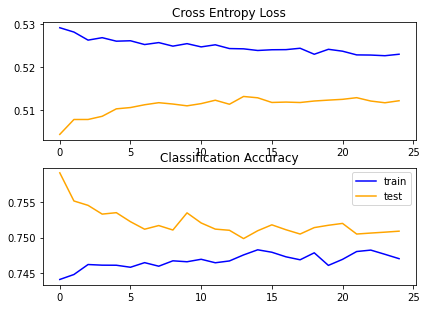

fold time:  0:01:56.349786
Fold 2
Test Index Start:80000
Test Set Size:40000


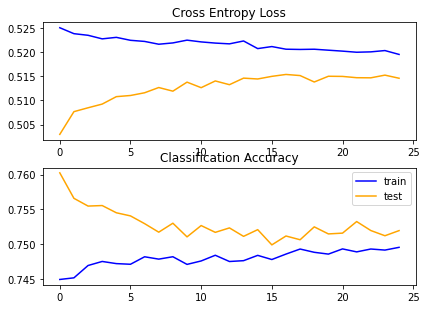

fold time:  0:01:59.289046
Fold 3
Test Index Start:120000
Test Set Size:40000


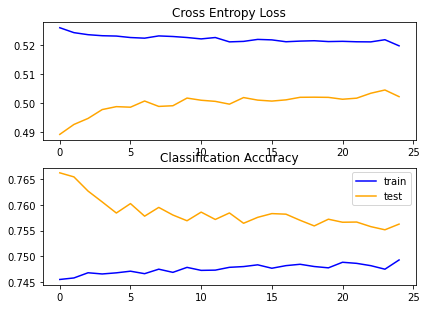

fold time:  0:01:50.526270
Fold 4
Test Index Start:160000
Test Set Size:40000


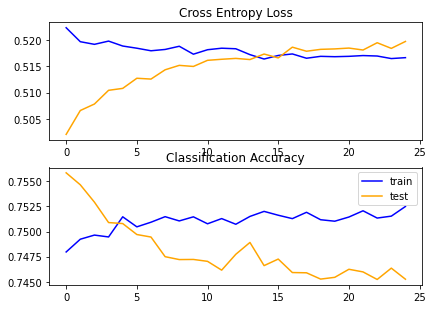

fold time:  0:01:50.574102


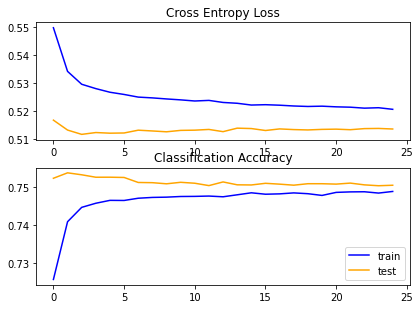

0:01:55.364354


In [6]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer=opt,
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

## CNN 2 Layer SGD Optimizer 1500 Words lr=0.0001 (crashed but clear underperformer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1000, 25)          150       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 500, 25)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 12)           912       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 250, 12)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3000)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

2022-05-01 20:26:02.489601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 20:26:04.529339: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


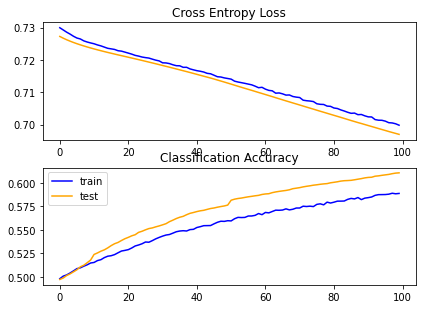

fold time:  0:05:20.971658
Fold 1
Test Index Start:40000
Test Set Size:40000


In [ ]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1000, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = SGD(learning_rate=0.0001)

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer=opt,
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1000)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

In [ ]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1000, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = SGD(learning_rate=0.001)

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer=opt,
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1000)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 25)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 12)           912       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 12)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

## CNN 2 Layer RMSprop Optimizer 1500 Words lr=0.0001

2022-05-01 19:33:31.836060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:33:31.904550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:33:31.905363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 25)          150       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 25)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 12)           912       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 12)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4500)              0         
                                                                 
 dense (Dense)               (None, 16)                7

2022-05-01 19:33:31.907570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 19:33:31.908619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:33:31.909407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:33:31.910165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Fold 0
Test Index Start:0
Test Set Size:40000


2022-05-01 19:34:23.250389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-01 19:34:25.307571: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


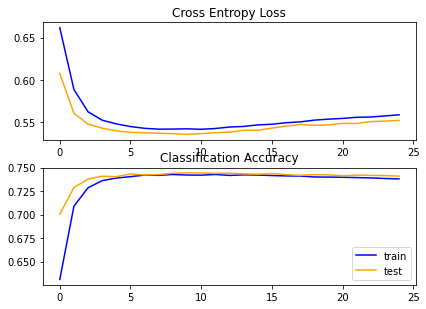

fold time:  0:01:54.395106
Fold 1
Test Index Start:40000
Test Set Size:40000


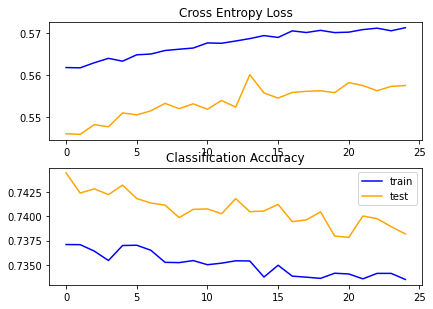

fold time:  0:01:51.328465
Fold 2
Test Index Start:80000
Test Set Size:40000


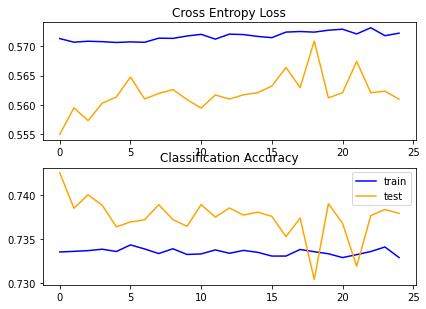

fold time:  0:01:51.481103
Fold 3
Test Index Start:120000
Test Set Size:40000


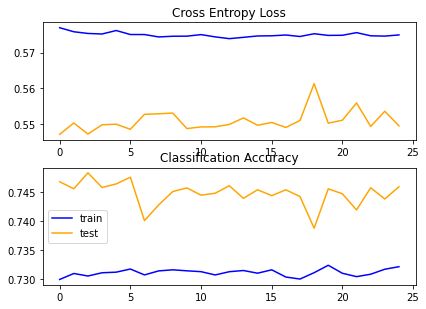

fold time:  0:01:51.402162
Fold 4
Test Index Start:160000
Test Set Size:40000


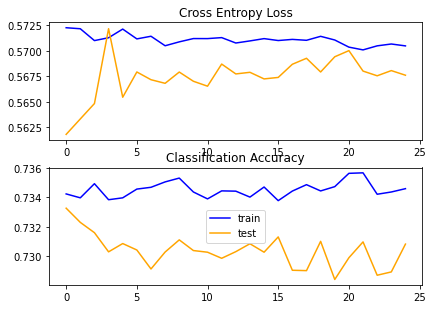

fold time:  0:01:51.386578


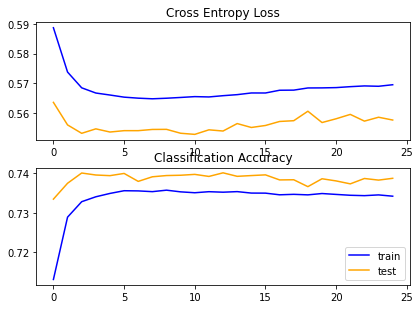

0:01:51.998683


In [4]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(25, 5, padding="same", activation="relu", input_shape=(1500, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = RMSprop(learning_rate=0.0001)

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer=opt,
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 1500)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])
kfold(model, neg_tweets_lemm[:200000], pos_tweets_lemm[:200000], 256)